In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
   Loan Repayment Prediction
'''

# Ownership
__author__ = ["M. Haseeb Hassan"]
__copyright__ = ["Copyrights @ hacceebhassan"]
__license__ = "MIT"
__version__ = "1.0.1"
__maintainer__ = "M. Haseeb Hassan"
__email__ = "hacceebhassan@gmail.com"
__status__ = "Development"

<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Predicting Loan Repayment</h1><br>

Let's load the data and check:
- Data types of each feature
- If we have missing values
- If we have imbalanced data

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import fancyimpute
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsemble
from mlens.visualization import corrmat
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import Imputer, RobustScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                             accuracy_score, roc_curve,
                             precision_recall_curve, f1_score)
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from keras import models, layers, optimizers

os.chdir("../")
from scripts.plot_roc import plot_roc_and_pr_curves
os.chdir("notebooks/")

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
[MLENS] backend: threading


In [2]:
# Load the data
df = pd.read_csv("data/loans.csv")

# Check both the datatypes and if there is missing values
print(f"\033[1m\033[94mData types:\n{11 * '-'}")
print(f"\033[30m{df.dtypes}\n")
print(f"\033[1m\033[94mSum of null values in each feature:\n{35 * '-'}")
print(f"\033[30m{df.isnull().sum()}")
df.head()

Data types:
-----------
credit_policy          int64
purpose               object
int_rate             float64
installment          float64
log_annual_inc       float64
dti                  float64
fico                   int64
days_with_cr_line    float64
revol_bal              int64
revol_util           float64
inq_last_6mths       float64
delinq_2yrs          float64
pub_rec              float64
not_fully_paid         int64
dtype: object

Sum of null values in each feature:
-----------------------------------
credit_policy         0
purpose               0
int_rate              0
installment           0
log_annual_inc        4
dti                   0
fico                  0
days_with_cr_line    29
revol_bal             0
revol_util           62
inq_last_6mths       29
delinq_2yrs          29
pub_rec              29
not_fully_paid        0
dtype: int64


credit_policy             purpose  int_rate  installment  log_annual_inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days_with_cr_line  revol_bal  revol_util  inq_last_6mths  \
0  19.48   737        5639.958333      28854        52.1             0.0   
1  14.29   707        2760.000000      33623        76.7             0.0   
2  11.63   682        4710.000000       3511        25.6             1.0   
3   8.10   712        2699.958333      33667        73.2             1.0   
4  14.97   667        4066.000000       4740        39.5             0.0   

   delinq_2yrs  pub_rec  not_fully_paid  
0          0.0      0.0               0  
1          0.0      0.0               0  
2          0.0      0.0               0  
3          0.0      0.0               0  
4          1.0      0.0               0

Positive examples = 1533
Negative examples = 8045
Proportion of positive to negative examples = 19.06%


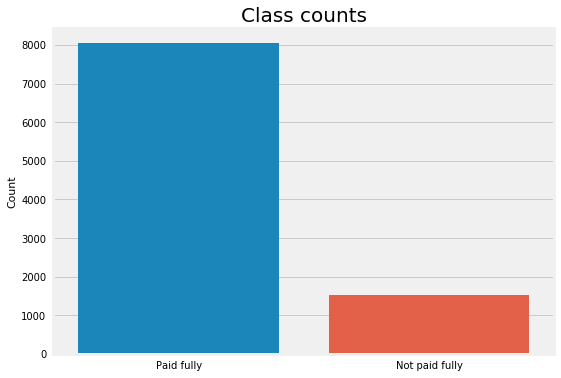

In [3]:
# Get number of positve and negative examples
pos = df[df["not_fully_paid"] == 1].shape[0]
neg = df[df["not_fully_paid"] == 0].shape[0]
print(f"Positive examples = {pos}")
print(f"Negative examples = {neg}")
print(f"Proportion of positive to negative examples = {(pos / neg) * 100:.2f}%")
plt.figure(figsize=(8, 6))
sns.countplot(df["not_fully_paid"])
plt.xticks((0, 1), ["Paid fully", "Not paid fully"])
plt.xlabel("")
plt.ylabel("Count")
plt.title("Class counts", y=1, fontdict={"fontsize": 20});

It looks like we have only one categorical feature ("purpose"). Also, six features have missing values (no missing values in labels). Moreover, the data set is pretty imbalanced as expected where positive examples ("not paid fully") are only 19%. We'll explain in the next section how to handle all of them after giving an overview of ensemble methods.

In [4]:
# Create dummy variables from the feature purpose
df = pd.get_dummies(df, columns=["purpose"], drop_first=True)
df.head()

credit_policy  int_rate  installment  log_annual_inc    dti  fico  \
0              1    0.1189       829.10       11.350407  19.48   737   
1              1    0.1071       228.22       11.082143  14.29   707   
2              1    0.1357       366.86       10.373491  11.63   682   
3              1    0.1008       162.34       11.350407   8.10   712   
4              1    0.1426       102.92       11.299732  14.97   667   

   days_with_cr_line  revol_bal  revol_util  inq_last_6mths  delinq_2yrs  \
0        5639.958333      28854        52.1             0.0          0.0   
1        2760.000000      33623        76.7             0.0          0.0   
2        4710.000000       3511        25.6             1.0          0.0   
3        2699.958333      33667        73.2             1.0          0.0   
4        4066.000000       4740        39.5             0.0          1.0   

   pub_rec  not_fully_paid  purpose_credit_card  purpose_debt_consolidation  \
0      0.0               0                    0                           1   
1      0.0               0                    1                           0   
2      0.0               0                    0                           1   
3      0.0               0                    0                           1   
4      0.0               0                    1                           0   

   purpose_educational  purpose_home_improvement  purpose_major_purchase  \
0                    0                         0                       0   
1                    0                         0                       0   
2                    0                         0                       0   
3                    0                         0                       0   
4                    0                         0                       0   

   purpose_small_business  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0

In [5]:
# Create binary features to check if the example is has missing values for all features that have missing values
for feature in df.columns:
    if np.any(np.isnan(df[feature])):
        df["is_" + feature + "_missing"] = np.isnan(df[feature]) * 1

df.head()

credit_policy  int_rate  installment  log_annual_inc    dti  fico  \
0              1    0.1189       829.10       11.350407  19.48   737   
1              1    0.1071       228.22       11.082143  14.29   707   
2              1    0.1357       366.86       10.373491  11.63   682   
3              1    0.1008       162.34       11.350407   8.10   712   
4              1    0.1426       102.92       11.299732  14.97   667   

   days_with_cr_line  revol_bal  revol_util  inq_last_6mths  \
0        5639.958333      28854        52.1             0.0   
1        2760.000000      33623        76.7             0.0   
2        4710.000000       3511        25.6             1.0   
3        2699.958333      33667        73.2             1.0   
4        4066.000000       4740        39.5             0.0   

          ...          purpose_educational  purpose_home_improvement  \
0         ...                            0                         0   
1         ...                            0                         0   
2         ...                            0                         0   
3         ...                            0                         0   
4         ...                            0                         0   

   purpose_major_purchase  purpose_small_business  is_log_annual_inc_missing  \
0                       0                       0                          0   
1                       0                       0                          0   
2                       0                       0                          0   
3                       0                       0                          0   
4                       0                       0                          0   

   is_days_with_cr_line_missing  is_revol_util_missing  \
0                             0                      0   
1                             0                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   

   is_inq_last_6mths_missing  is_delinq_2yrs_missing  is_pub_rec_missing  
0                          0                       0                   0  
1                          0                       0                   0  
2                          0                       0                   0  
3                          0                       0                   0  
4                          0                       0                   0  

[5 rows x 25 columns]

In [6]:
# Original Data
X = df.loc[:, df.columns != "not_fully_paid"].values
y = df.loc[:, df.columns == "not_fully_paid"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"Original data shapes: {X_train.shape, X_test.shape}")

# Drop NA and remove binary columns
train_indices_na = np.max(np.isnan(X_train), axis=1)
test_indices_na = np.max(np.isnan(X_test), axis=1)
X_train_dropna, y_train_dropna = X_train[~train_indices_na, :][:, :-6], y_train[~train_indices_na]
X_test_dropna, y_test_dropna = X_test[~test_indices_na, :][:, :-6], y_test[~test_indices_na]
print(f"After dropping NAs: {X_train_dropna.shape, X_test_dropna.shape}")

# MICE data
mice = fancyimpute.MICE(verbose=0)
X_mice = mice.complete(X)
X_train_mice, X_test_mice, y_train_mice, y_test_mice = train_test_split(
    X_mice, y, test_size=0.2, shuffle=True, random_state=123, stratify=y)
print(f"MICE data shapes: {X_train_mice.shape, X_test_mice.shape}")

Original data shapes: ((7662, 24), (1916, 24))
After dropping NAs: ((7611, 18), (1905, 18))
MICE data shapes: ((7662, 24), (1916, 24))


In [7]:
# Build random forest classifier
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")
# Build base line model -- Drop NA's
pip_baseline = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_baseline,
                         X_train_dropna, y_train_dropna,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mBaseline model's average AUC: {scores.mean():.3f}")

# Build model with mean imputation
pip_impute_mean = make_pipeline(Imputer(strategy="mean"),
                                RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mean,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMean imputation model's average AUC: {scores.mean():.3f}")

# Build model with median imputation
pip_impute_median = make_pipeline(Imputer(strategy="median"),
                                  RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_median,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMedian imputation model's average AUC: {scores.mean():.3f}")

# Build model using MICE imputation
pip_impute_mice = make_pipeline(RobustScaler(), rf_clf)
scores = cross_val_score(pip_impute_mice,
                         X_train_mice, y_train_mice,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mMICE imputation model's average AUC: {scores.mean():.3f}")

Baseline model's average AUC: 0.651
Mean imputation model's average AUC: 0.651
Median imputation model's average AUC: 0.651
MICE imputation model's average AUC: 0.656


Let's plot the feature importances to check if the added binary features added anything to the model.

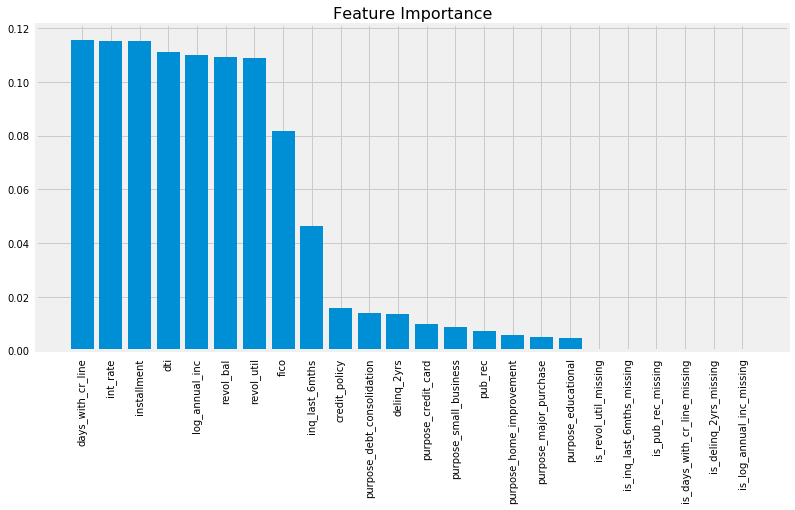

In [8]:
# fit RF to plot feature importances
rf_clf.fit(RobustScaler().fit_transform(Imputer(strategy="median").fit_transform(X_train)), y_train)

# Plot features importance
importances = rf_clf.feature_importances_
indices = np.argsort(rf_clf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 25), importances[indices], align="center")
plt.xticks(range(1, 25), df.columns[df.columns != "not_fully_paid"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

Guided by the 10-fold cross validation *AUC* scores, it looks like all strategies have comparable results and missing values were generated randomly. Also, the added six binary features showed no importance when plotting feature importances from *Random Forest* classifier. Therefore, it's safe to drop those features and use *Median Imputation* method as a transformer later on in the pipeline.

In [9]:
# Drop generated binary features
X_train = X_train[:, :-6]
X_test = X_test[:, :-6]

In [10]:
# Build random forest classifier (same config)
rf_clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.25,
                                criterion="entropy",
                                class_weight="balanced")

# Build model with no sampling
pip_orig = make_pipeline(Imputer(strategy="mean"),
                         RobustScaler(),
                         rf_clf)
scores = cross_val_score(pip_orig,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOriginal model's average AUC: {scores.mean():.3f}")

# Build model with undersampling
pip_undersample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomUnderSampler(), rf_clf)
scores = cross_val_score(pip_undersample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mUnder-sampled model's average AUC: {scores.mean():.3f}")

# Build model with oversampling
pip_oversample = imb_make_pipeline(Imputer(strategy="mean"),
                                    RobustScaler(),
                                    RandomOverSampler(), rf_clf)
scores = cross_val_score(pip_oversample,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mOver-sampled model's average AUC: {scores.mean():.3f}")

# Build model with EasyEnsemble
resampled_rf = BalancedBaggingClassifier(base_estimator=rf_clf,
                                         n_estimators=10, random_state=123)
pip_resampled = make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(), resampled_rf)
                             
scores = cross_val_score(pip_resampled,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mEasyEnsemble model's average AUC: {scores.mean():.3f}")

# Build model with SMOTE
pip_smote = imb_make_pipeline(Imputer(strategy="mean"),
                              RobustScaler(),
                              SMOTE(), rf_clf)
scores = cross_val_score(pip_smote,
                         X_train, y_train,
                         scoring="roc_auc", cv=10)
print(f"\033[1m\033[94mSMOTE model's average AUC: {scores.mean():.3f}")

Original model's average AUC: 0.652
Under-sampled model's average AUC: 0.656
Over-sampled model's average AUC: 0.651
EasyEnsemble model's average AUC: 0.665
SMOTE model's average AUC: 0.641


EasyEnsemble method has the highest 10-folds CV with average AUC = 0.665.

In [11]:
# Impute the missing data using features means
imp = Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)

# Standardize the data
std = RobustScaler()
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

# Implement RandomUnderSampler
random_undersampler = RandomUnderSampler()
X_res, y_res = random_undersampler.fit_sample(X_train, y_train)
# Shuffle the data
perms = np.random.permutation(X_res.shape[0])
X_res = X_res[perms]
y_res = y_res[perms]
X_res.shape, y_res.shape

((2452, 18), (2452,))

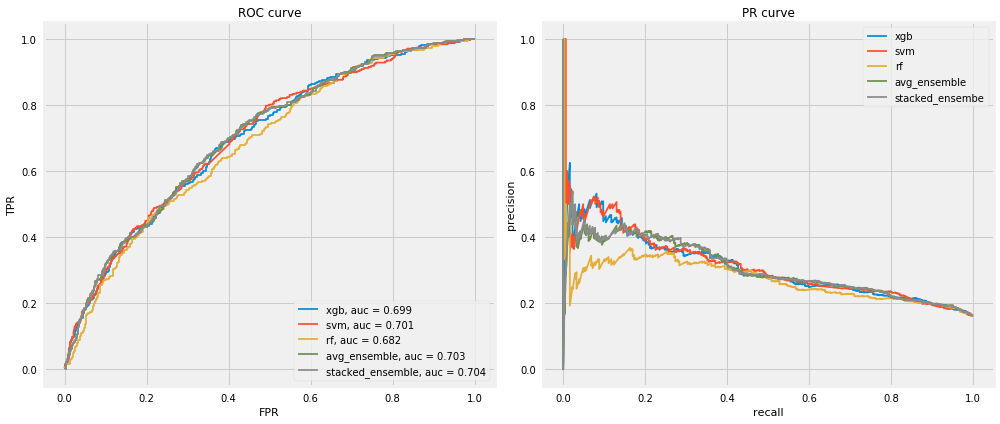

In [12]:
# Define base learners
xgb_clf = xgb.XGBClassifier(objective="binary:logistic",
                            learning_rate=0.03,
                            n_estimators=500,
                            max_depth=1,
                            subsample=0.4,
                            random_state=123)

svm_clf = SVC(gamma=0.1,
                C=0.01,
                kernel="poly",
                degree=3,
                coef0=10.0,
                probability=True)

rf_clf = RandomForestClassifier(n_estimators=300,
                                max_features="sqrt",
                                criterion="gini",
                                min_samples_leaf=5,
                                class_weight="balanced")

# Define meta-learner
logreg_clf = LogisticRegression(penalty="l2",
                                C=100,
                                fit_intercept=True)

# Fitting voting clf --> average ensemble
voting_clf = VotingClassifier([("xgb", xgb_clf),
                               ("svm", svm_clf),
                               ("rf", rf_clf)],
                              voting="soft",
                              flatten_transform=True)
voting_clf.fit(X_res, y_res)
xgb_model, svm_model, rf_model = voting_clf.estimators_
models = {"xgb": xgb_model, "svm": svm_model,
          "rf": rf_model, "avg_ensemble": voting_clf}

# Build first stack of base learners
first_stack = make_pipeline(voting_clf,
                            FunctionTransformer(lambda X: X[:, 1::2]))
# Use CV to generate meta-features
meta_features = cross_val_predict(first_stack,
                                  X_res, y_res,
                                  cv=10,
                                  method="transform")
# Refit the first stack on the full training set
first_stack.fit(X_res, y_res)
# Fit the meta learner
second_stack = logreg_clf.fit(meta_features, y_res)

# Plot ROC and PR curves using all models and test data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for name, model in models.items():
            model_probs = model.predict_proba(X_test)[:, 1:]
            model_auc_score = roc_auc_score(y_test, model_probs)
            fpr, tpr, _ = roc_curve(y_test, model_probs)
            precision, recall, _ = precision_recall_curve(y_test, model_probs)
            axes[0].plot(fpr, tpr, label=f"{name}, auc = {model_auc_score:.3f}")
            axes[1].plot(recall, precision, label=f"{name}")
stacked_probs = second_stack.predict_proba(first_stack.transform(X_test))[:, 1:]
stacked_auc_score = roc_auc_score(y_test, stacked_probs)
fpr, tpr, _ = roc_curve(y_test, stacked_probs)
precision, recall, _ = precision_recall_curve(y_test, stacked_probs)
axes[0].plot(fpr, tpr, label=f"stacked_ensemble, auc = {stacked_auc_score:.3f}")
axes[1].plot(recall, precision, label="stacked_ensembe")
axes[0].legend(loc="lower right")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC curve")
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("PR curve")
plt.tight_layout()

As we can see from the chart above, stacked ensemble model didn't improve the performance. One of the major reasons are that the base learners are considerably highly correlated especially *Random Forest* and *Gradient Boosting* (see the correlation matrix below).

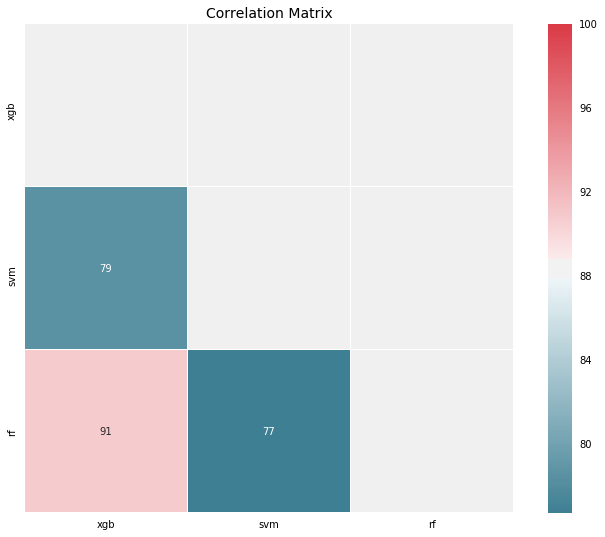

In [17]:
# Plot the correlation between base learners
probs_df = pd.DataFrame(meta_features, columns=["xgb", "svm", "rf"])
corrmat(probs_df.corr(), inflate=True);

In addition, with classification problems where False Negatives are a lot more expensive than False Positives, we may want to have a model with a high precision rather than high recall, i.e. the probability of the model to identify positive examples from randomly selected examples. Below is the confusion matrix:

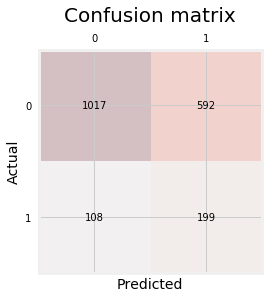

In [78]:
second_stack_probs = second_stack.predict_proba(first_stack.transform(X_test))
second_stack_preds = second_stack.predict(first_stack.transform(X_test))
conf_mat = confusion_matrix(y_test, second_stack_preds)
# Define figure size and figure ratios
plt.figure(figsize=(16, 8))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)
for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center")
plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14});

Let's finally check the partial dependence plots to see what are the most important features and their relationships with whether the borrower will most likely pay the loan in full before mature data. we will plot only the top 8 features to make it easier to read.

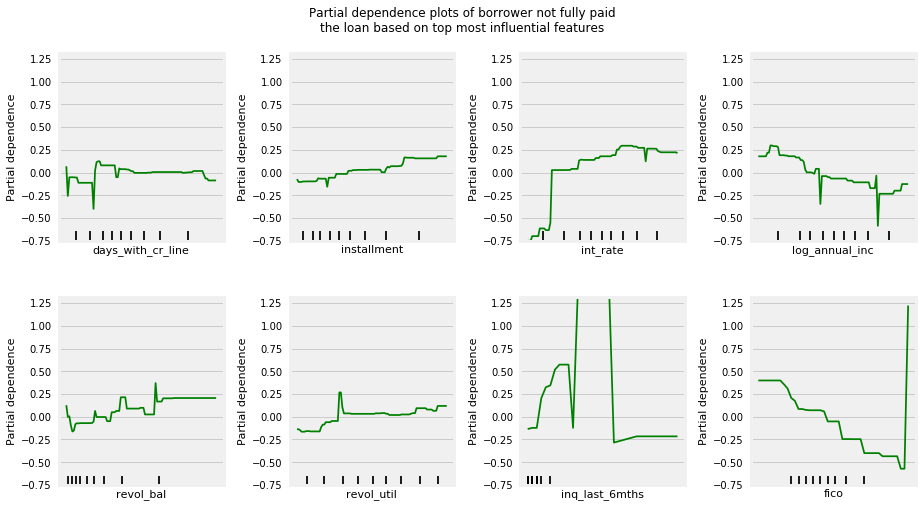

In [24]:
# Plot partial dependence plots
gbrt = GradientBoostingClassifier(loss="deviance",
                                  learning_rate=0.1,
                                  n_estimators=100,
                                  max_depth=3,
                                  random_state=123)
gbrt.fit(X_res, y_res)
fig, axes = plot_partial_dependence(gbrt, X_res,
                                    np.argsort(gbrt.feature_importances_)[::-1][:8],
                                    n_cols=4,
                                    feature_names=df.columns[:-6],
                                    figsize=(14, 8))
plt.subplots_adjust(top=0.9)
plt.suptitle("Partial dependence plots of borrower not fully paid\n"
             "the loan based on top most influential features")
for ax in axes: ax.set_xticks(())
for ax in [axes[0], axes[4]]: ax.set_ylabel("Partial dependence")

As we might expected, borrowers with lower annual income and less FICO scores are less likely to pay the loan fully; however, borrowers with lower interest rates (riskier) and smaller installments are more likely to pay the loan fully.